Please upload the 'bank-additional-full.csv' file.


Saving bank-additional-full.csv to bank-additional-full (1).csv

Successfully loaded bank-additional-full (1).csv

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  o

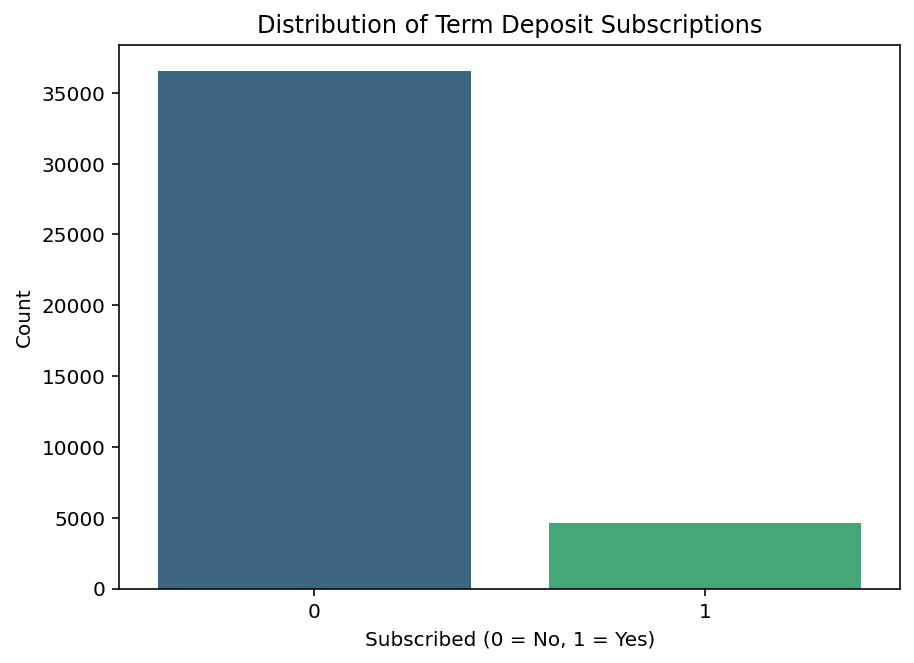


--- Model Training and Evaluation ---


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import io

# ==============================================================================
# 1. LOAD THE DATA (USER-FRIENDLY METHOD FOR COLAB/JUPYTER)
# ==============================================================================
# This try-except block handles loading the data in different environments.
# In Google Colab, it will prompt for a file upload.
# In a local environment, it will look for the file in the same folder.
try:
    from google.colab import files
    print("Please upload the 'bank-additional-full.csv' file.")
    uploaded = files.upload()
    file_name = next(iter(uploaded)) # Get the name of the uploaded file
    df = pd.read_csv(io.BytesIO(uploaded[file_name]), sep=';')
    print(f"\nSuccessfully loaded {file_name}")

except (ModuleNotFoundError, ImportError):
    file_path = 'bank-additional-full.csv'
    try:
        df = pd.read_csv(file_path, sep=';')
        print(f"Successfully loaded {file_path} from local directory.")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure it is in the same folder as your script or notebook.")
        exit()

# ==============================================================================
# 2. DATA UNDERSTANDING & PREPARATION
# ==============================================================================
print("\n--- Data Info ---")
df.info()

print("\n--- Descriptive Statistics (Numerical) ---")
print(df.describe())

# Convert target variable 'y' to numeric (1 for 'yes', 0 for 'no')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# --- Visualize Target Variable Distribution ---
plt.figure(figsize=(7, 5))
sns.countplot(x='y', data=df, palette='viridis')
plt.title('Distribution of Term Deposit Subscriptions')
plt.xlabel('Subscribed (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# ==============================================================================
# 3. PREPROCESSING AND MODEL PIPELINE
# ==============================================================================
# Define features (X) and target (y)
# Drop 'duration' due to data leakage - it's a post-call metric.
X = df.drop(columns=['y', 'duration'])
y = df['y']

# Identify categorical and numerical features for transformations
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create a preprocessing pipeline
# StandardScaler for numerical features, OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training and testing sets
# Use stratify=y to ensure the train/test split has a similar proportion of the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# ==============================================================================
# 4. DEFINE, TRAIN, AND EVALUATE MODELS
# ==============================================================================
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42)
}

results = {}

print("\n--- Model Training and Evaluation ---")
for name, model in models.items():
    # Create the full pipeline: preprocess data, then apply classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Store the results
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, target_names=['No', 'Yes']),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

# ==============================================================================
# 5. DISPLAY AND COMPARE RESULTS
# ==============================================================================
for name, result in results.items():
    print(f"\n--- Results for {name} ---")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()